# PyTorch for Computer Vision<br/>Example 1 - Convolutional Bebezal Network
## TDC SP 2019 - Track: Machine Learning

**After this notebook, you'll be able to:**
- Use a folder with labels as subfolders as a dataset
- Split train dataset into train and val datasets
- Apply transformations in images for data augmentation
- Create a Convolutional Neural Network
- Detect faces in a image
- Train and validate your Convolutional Neural Network
- Analyze metrics obtained in training task
- Run inference in test dataset

Let's start ... Importing libraries ...

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import inspect
import time
import os
import copy

In [2]:
# check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## 1. Loading and Preparing Data

- Defining a Transform Pipeline
- Use a image folder as dataset
- Create Loader for Train, Val and Test Sets
- Visualize some samples

In [70]:
# Create a transform pipeline (Compose), doing:
#   - Random Horizontal Flip
#   - Random Rotation in 20 degrees
#   - Resize image to 96x96
#   - Transforming image in Tensor
#   - Normalizing using mean = 0.5 and std = 0.5. 
#   - Normalize is applied in each channel (RGB) and in the code below does: image = (image - mean) / std, normalizing the image in the range [-1,1].

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(size=(99,99)),
    transforms.RandomCrop(size=(96,96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [106]:
# Loader parameters
batch_size = 8
num_workers = 0

# percentage of train set for validation and test set
test_size = 0.3
valid_size = 0.1

In [107]:
# Get image dataset
train_data = datasets.ImageFolder('../dataset', transform=transform)
print(train_data)

Dataset ImageFolder
    Number of datapoints: 30
    Root location: ../dataset


In [108]:
# Split train dataset for test dataset
num_data = len(train_data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

# Split train dataset for validation dataset
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

In [109]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [110]:
# Create Loaders for Train, Validation and Test Datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

In [111]:
# Print Dataset Stats
print('# training images: ', len(train_sampler))
print('# validation images: ', len(valid_sampler))
print('# test images: ', len(test_sampler))
print('Classes: ', train_data.classes)

# training images:  19
# validation images:  2
# test images:  9
Classes:  ['alegre', 'brabo', 'sonado']


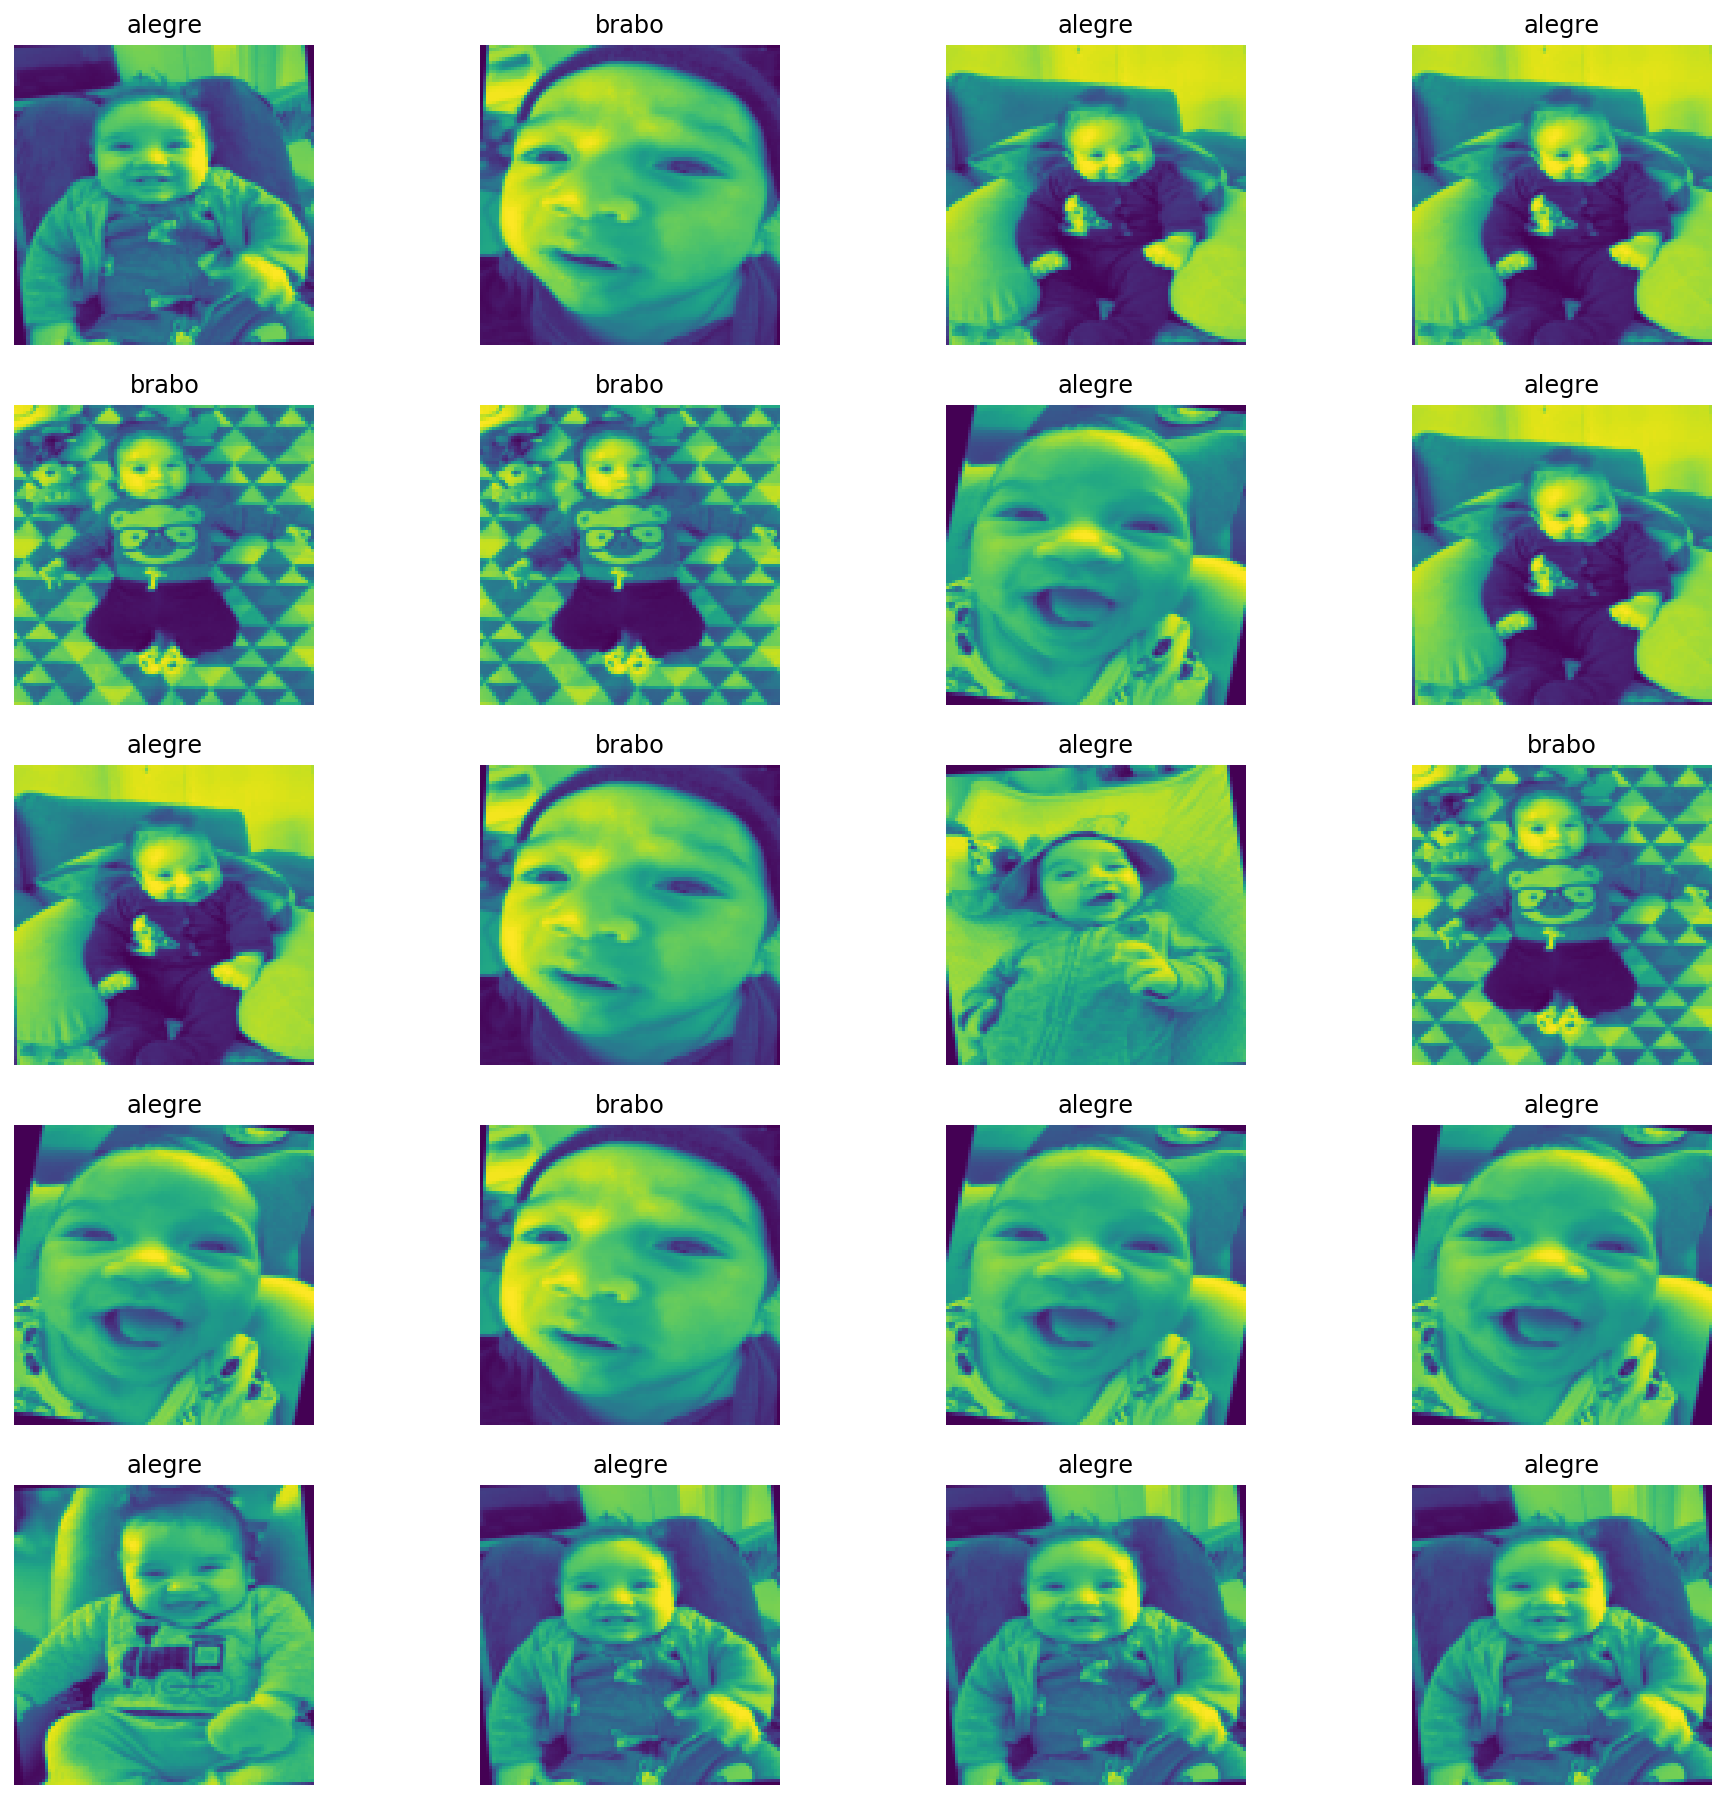

In [112]:
# Visualize Some sample data

# Obtaning first batch of training images, through iterator of DataLoader
dataiter = iter(train_loader)
images, labels = dataiter.next()

labels_map = {0 : 'alegre', 1 : 'brabo', 2 : 'sonado'};

fig = plt.figure(figsize=(16,16));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(images));
    img = images[img_xy][0]
    fig.add_subplot(rows, columns, i)
    plt.title(str(labels_map[int(labels[img_xy])]))
    plt.axis('off')
    plt.imshow(img)
plt.show()

## 2. Create CNN for Facial Expression

- Create model class with architecture of CNN
- Define CNN hyperparameters (Loss, Optimizer, Learning Rate)

In [113]:
class BebezalNet(nn.Module):
    def __init__(self):
        super(BebezalNet, self).__init__()
        
        # layer #1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional layer #2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional layer #3
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(10 * 10 * 256, 1024)
        self.fc2 = nn.Linear(1024, 3)
        # self.log_softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # print(out.shape)
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # out = self.log_softmax(self.fc2(out))
        return out

# Create a instance of BebezalNet
model = BebezalNet()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [114]:
print(model)

BebezalNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
)


In [115]:
# Hyperparameters

# Loss = CrossEntropy
criterion = nn.CrossEntropyLoss()

# Optimize with SGD (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

## 3. Train Model

- Get batch of images from Trainloader
- Clear Gradients
- Forward Prop
- Calculate Loss
- Backward Prop (using Autograd)
- Run Optimizer (SGD) with Hyperparameters
- Save model

In [116]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [117]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    
    start_ts = time.time()
    
    losses = []
    batches = len(trainloader)
    val_batches = len(valloader)
    
    # loop for every epoch (training + evaluation)
    for epoch in range(num_epochs):
        total_loss = 0

        # progress bar (works in Jupyter notebook too!)
        progress = tqdm(enumerate(trainloader), desc="Loss: ", total=batches)

        # ----------------- TRAINING  -------------------- 
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # getting training quality data
            current_loss = loss.item()
            total_loss += current_loss

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

        # releasing unnecessary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valloader):
                X, y = data[0].to(device), data[1].to(device)

                outputs = model(X) # this get's the prediction from the network

                val_losses += criterion(outputs, y)

                predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

                # calculate P/R/F1/A metrics for batch
                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(
                        calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                    )

        print(f"Epoch {epoch+1}/{num_epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
        print_scores(precision, recall, f1, accuracy, val_batches)
        losses.append(total_loss/batches) # for plotting learning curve
    print(f"Training time: {time.time()-start_ts}s")

In [119]:
train_model(model, train_loader, valid_loader, criterion, optimizer, 25)

Epoch 1/25, training loss: 0.8262043595314026, validation loss: 1.0839295387268066
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 2/25, training loss: 0.7966673175493876, validation loss: 1.1058520078659058
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 3/25, training loss: 0.7962438662846884, validation loss: 1.1081101894378662
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 4/25, training loss: 0.7688216169675192, validation loss: 1.031477689743042
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 5/25, training loss: 0.7464315891265869, validation loss: 0.955847978591919
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 6/25, training loss: 0.959279477596283, validation loss: 0.9595015645027161
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 7/25, training loss: 0.7633023262023926, validation loss: 0.9076704382896423
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 8/25, training loss: 0.8904294768969218, validation loss: 0.8699590563774109
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 9/25, training loss: 0.7313897609710693, validation loss: 0.9849459528923035
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 10/25, training loss: 0.7368929386138916, validation loss: 1.037405252456665
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 11/25, training loss: 0.709948460261027, validation loss: 1.0631250143051147
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 12/25, training loss: 0.6927832961082458, validation loss: 0.994084358215332
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 13/25, training loss: 0.6775400439898173, validation loss: 1.026724100112915
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 14/25, training loss: 0.6332287093003591, validation loss: 1.167277455329895
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 15/25, training loss: 0.6464822093645731, validation loss: 1.288099765777588
	     precision: 0.0000
	        recall: 0.0000
	            F1: 0.0000
	      accuracy: 0.0000


Epoch 16/25, training loss: 0.6562866270542145, validation loss: 1.3574564456939697
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 17/25, training loss: 0.5348020792007446, validation loss: 1.3716470003128052
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 18/25, training loss: 0.6020922362804413, validation loss: 1.6785087585449219
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 19/25, training loss: 0.508394738038381, validation loss: 1.9967637062072754
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 20/25, training loss: 0.4455648461977641, validation loss: 2.1739954948425293
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 21/25, training loss: 0.41501834988594055, validation loss: 2.4027726650238037
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 22/25, training loss: 0.37661618491013843, validation loss: 3.0789620876312256
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 23/25, training loss: 0.36974626282850903, validation loss: 3.4252986907958984
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 24/25, training loss: 0.3424704571564992, validation loss: 3.505021095275879
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000


Epoch 25/25, training loss: 0.32699323693911236, validation loss: 4.241421699523926
	     precision: 0.5000
	        recall: 0.2500
	            F1: 0.3333
	      accuracy: 0.5000
Training time: 118.11915802955627s


In [120]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')